### Importing the Cancer dataset along with other necessary modules

In [68]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import plot_tree
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

In [2]:
cancer_data = load_breast_cancer()
X_train, X_test,y_train, y_test = train_test_split(cancer_data.data, cancer_data.target,
                                                    stratify=cancer_data.target, random_state=10)
tree_model = DecisionTreeClassifier(random_state=100)
tree_model.fit(X_train, y_train)
score = tree_model.score(X_test, y_test)
print('Score on training data = {:.3f}'.format(tree_model.score(X_train, y_train)))
print('Score on test data = {:.3f}'.format(tree_model.score(X_test, y_test)))

Score on training data = 1.000
Score on test data = 0.944


As expected, the accuracy on the training dataset is 100%, because the leaves are pure. The tree could perfectly memorize all the labels on the training data. Now applying some pre-pruning to the tree, we get

Varying max_depth

In [4]:
tree_model = DecisionTreeClassifier(max_depth=4)
tree_model.fit(X_train, y_train)
score = tree_model.score(X_test, y_test)
print('Score on training data = {:.3f}'.format(tree_model.score(X_train, y_train)))
print('Score on test data = {:.3f}'.format(tree_model.score(X_test, y_test)))

Score on training data = 0.988
Score on test data = 0.944


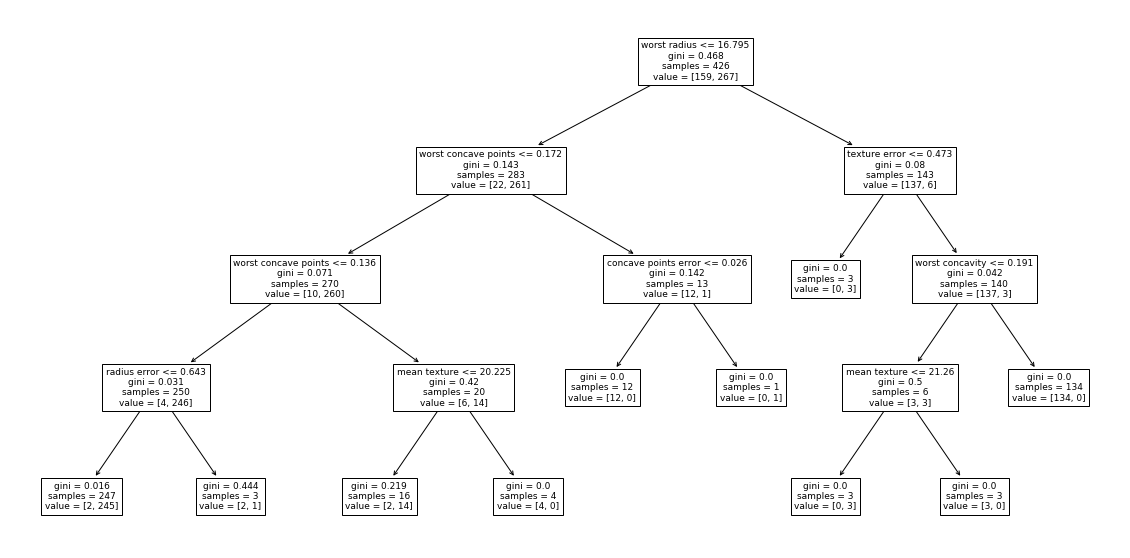

In [5]:
plt.figure(figsize=(20,10))
tree_dot = plot_tree(tree_model, feature_names=cancer_data.feature_names)

Varying max_leaf_nodes

In [6]:
tree_model = DecisionTreeClassifier(max_leaf_nodes=10)
tree_model.fit(X_train, y_train)
score = tree_model.score(X_test, y_test)
print('Score on training data = {:.3f}'.format(tree_model.score(X_train, y_train)))
print('Score on test data = {:.3f}'.format(tree_model.score(X_test, y_test)))

Score on training data = 0.988
Score on test data = 0.944


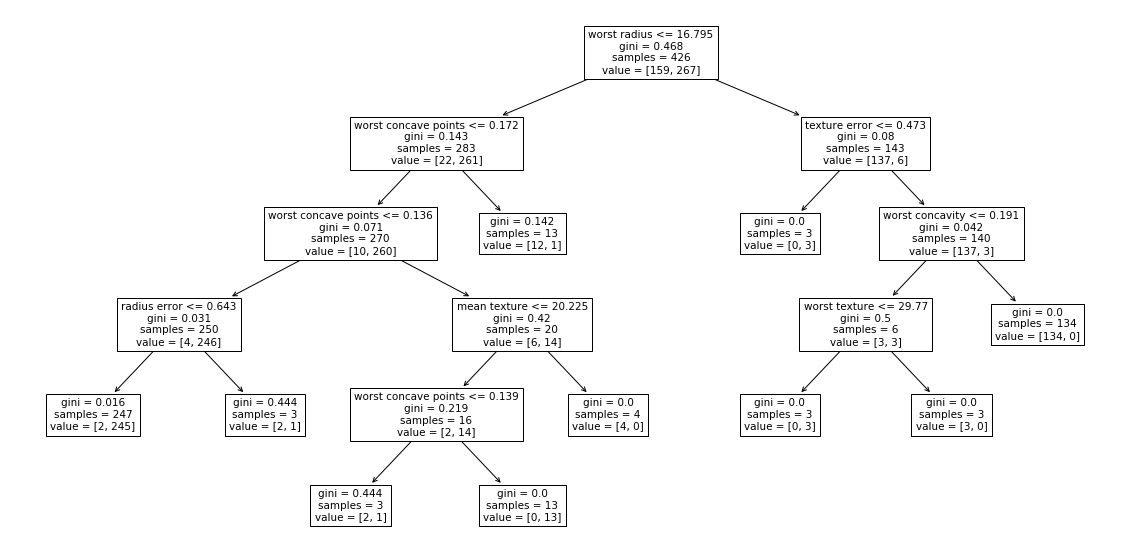

In [7]:
plt.figure(figsize=(20,10))
tree_dot2 = plot_tree(tree_model, feature_names=cancer_data.feature_names)

Classes are specified in the order of malignant, benign. At each stage, one feature is used to create the split. Max depth 4 is a reasonable point to stop as the classes at the leaves are more or less clear.
Gini index and cross-entropy are measures of impurity at a node. Gini is defined as follows:   
**H_gini(X_m) = p1(1 - p1) + p2(1 - p2)** *where 1 and 2 are the classes*   
Cross-entropy is defined as follows:   
**H_ce = -{p1.log(p1) + p2.log(p2)}**

#### Tuning parameters for pre-pruning:
1. Tuning max_depth means the prediction won't be very fine-grained as the depth of the tree is uniform theroughout the tree. However, the predictions will be very fast because we never go very deep in the tree. More RAM is consumed if we're building a large number of trees.
2. max_leaf_nodes: Prioritizes nodes that will have the greatest impurity decrease. There can be different depths in different parts of the tree.
3. min_samples_split: Only split nodes that have specified number of samples in them.
4. min_samples_leaf: The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.
5. min_weight_fraction: The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node. Samples have equal weight when sample_weight is not provided.

### Feature importances

In [8]:
print(tree_model.feature_importances_)

[0.         0.02567738 0.         0.         0.         0.
 0.         0.         0.         0.         0.01347305 0.02947698
 0.         0.         0.         0.         0.         0.
 0.         0.         0.77154689 0.01572085 0.         0.
 0.         0.         0.0150471  0.12905776 0.         0.        ]


#### Plotting feature importances

In [11]:
def plot_feature_importances_cancer(model):
    n_features = cancer_data.data.shape[1]
    plt.barh(np.arange(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), cancer_data.feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

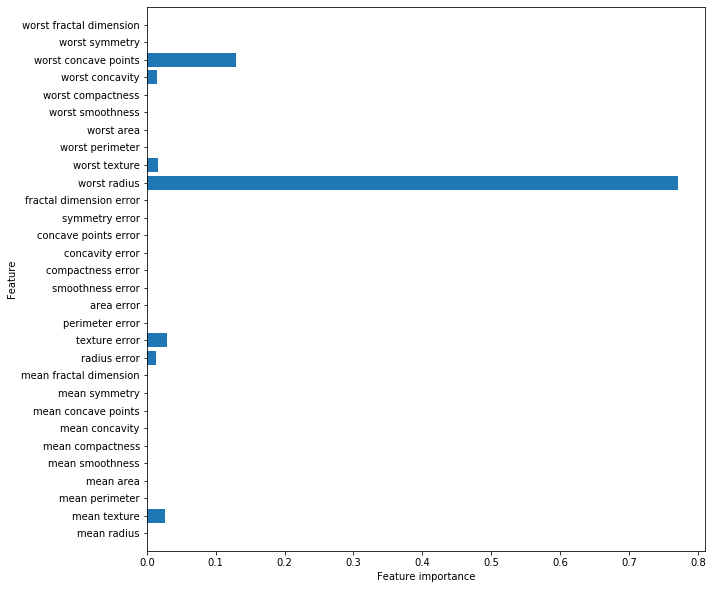

In [14]:
plt.figure(figsize=(10,10))
plot_feature_importances_cancer(tree_model)


Here we see that the feature used in the top split (“worst radius”) is by far the most
important feature. This confirms our observation in analyzing the tree that the first
level already separates the two classes fairly well.   
However, **if a feature has a low value in feature_importance_, it doesn’t mean that
this feature is uninformative. It only means that the feature was not picked by the
tree, likely because another feature encodes the same information.**   
In contrast to the coefficients in linear models, **feature importances are always positive,
and don’t encode which class a feature is indicative of.** The feature importances
tell us that “worst radius” is important, but not whether a high radius is indicative of a
sample being benign or malignant.

#### Cost complexity pruning
We can use cost complexity pruning for more effcient pruning. The formula is given as follows:   
> `R_alpha(T) = R(T) + alpha.|T|`

where R(T) is total leaf impurity   
|T| is no. of leaf nodes, and    
alpha is free parameter

In [15]:
param_grid = {'ccp_alpha': np.linspace(0, 0.03, 20)}
grid = GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid=param_grid, cv=10, return_train_score=True)
grid.fit(X_train, y_train)
score = grid.score(X_test, y_test)
print("Best cross validation score {:.3f}".format(grid.best_score_))
print("Test score {:.3f}".format(score))
print("best parameters: {}".format(grid.best_params_))

Best cross validation score 0.958
Test score 0.909
best parameters: {'ccp_alpha': 0.015789473684210527}


In [31]:
tree_model = make_pipeline(DecisionTreeClassifier(ccp_alpha=0.015789473684210527))
tree_model.fit(X_train, y_train)
cross_val_scores = cross_val_score(tree_model, X_train, y_train, cv=10)
print("score: {:.3f}".format(np.mean(cross_val_scores)))

score: 0.958


[0.         0.00232841 0.00312989 0.00312989 0.00433369 0.00508607
 0.00603534 0.00689135 0.00925735 0.0132044  0.04571383 0.34561937]
********
[0.         0.00931364 0.01244353 0.01557342 0.01990712 0.02499319
 0.03102853 0.04481123 0.06332592 0.07653032 0.12224415 0.46786352]


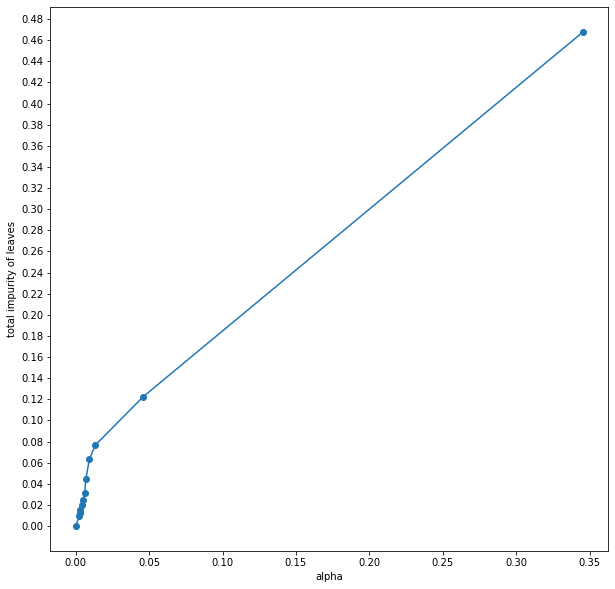

In [35]:
import matplotlib.pyplot as plt

clf = DecisionTreeClassifier(random_state=20)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print(ccp_alphas)
print('********')
print(impurities)
plt.figure(figsize=(10,10))
plt.plot(ccp_alphas, impurities, marker='o')
plt.yticks(np.arange(0, 0.5, step=0.02))
plt.xticks()
plt.xlabel('alpha')
plt.ylabel('total impurity of leaves')

plt.show()

The above graph is weird. It should actually be showing a stepped graph where value of impurity remains constant for several values of alpha and then increases, but here we see a different graph.

### Regression using Decision Trees
Regression using trees is very similar to the classification task discussed above. An important asspect of DecisionTreeRegressor is that it is unable to extrapolate, ie make predictions outside the range of training data.   
While the tree model makes the best predictions on the training data, **it cannot make predictions on test inputs that fall outside the range of training data and keep predicting the last known point. This restriction applies to all tree-based models.**
If there are corelated features, then a decision tree will pick one of them, like the L1 norm.

Usually trees can work directly on categorical variables. However, we have to encode them using OneHotEncoder (or some other encoder) because sklearn doesn't support running trees directly on categorical variables.


#### Drawbacks of decision trees:
1. Decision trees are unpredictable. For the same dataset, one decison tree can give great results, while another can be bad.
2. They tend to overfit and provide poor generalization performance.
3. They can't extrapolate.   
Ensemble methods, which combine results from many different trees, are a better choice.

## Ensemble models
### Random forests
A random forest is essentially a collection of decision trees, where each tree is slightly different from
the others. The idea behind random forests is that each tree might do a relatively
good job of predicting, but will likely overfit on part of the data. If we build many
trees, all of which work well and overfit in different ways, we can reduce the amount
of overfitting by averaging their results.

There are two ways randomization is achieved in random forests:
1. **Selecting data points used to build a tree:** take what is called a bootstrap sample of our data - from our n_samples data points, we repeatedly draw an example randomly with replacement
2. **Selecting the features in each split test:** Instead of looking for the best test for each node, in each node the algorithm randomly selects a subset of the features, and it looks for the best possible test involving one of these features. The number of features that are selected is controlled by the max_features parameter. This selection of a subset of features is repeated separately in each node, so that each node in a tree can make a decision using a different subset of the features.   

The bootstrap sampling leads to each decision tree in the random forest being built
on a slightly different dataset. Because of the selection of features in each node, each
split in each tree operates on a different subset of features. Together, these two mechanisms
ensure that all the trees in the random forest are different.   
If max_features = n_features, then we lose the randomness introduced in (2). If max_features = 1, then the splits have no choice over which feature to test, and can only search over different thresholds for the feature that was selected randomly.   

A high max_features means that the trees in the random forest will be quite similar, and they will be
able to fit the data easily, using the most distinctive features. A low max_features
means that the trees in the random forest will be quite different, and that each tree
might need to be very deep in order to fit the data well.

In [42]:
X, y = make_moons(n_samples=100, noise=0.25, random_state=3)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
random_state=42)
forest = RandomForestClassifier(n_estimators=5, random_state=2)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=5,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)

In [43]:
import mglearn

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


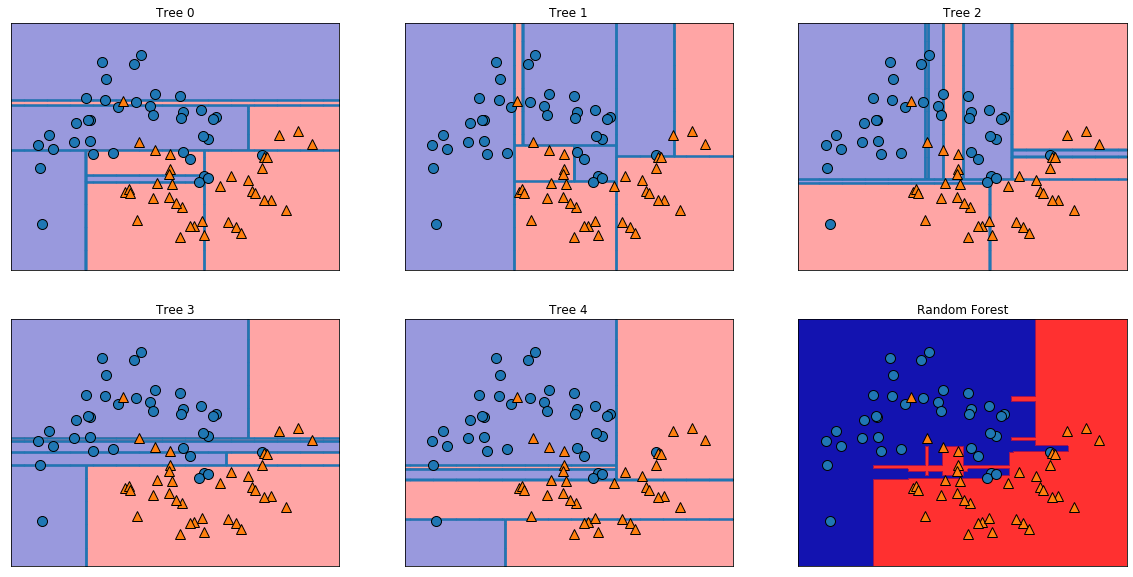

In [46]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for i, (ax, tree) in enumerate(zip(axes.ravel(), forest.estimators_)):
    ax.set_title("Tree {}".format(i))
    mglearn.plots.plot_tree_partition(X_train, y_train, tree, ax=ax)
    mglearn.plots.plot_2d_separator(forest, X_train, fill=True, ax=axes[-1, -1],
                                    alpha=.4)
axes[-1, -1].set_title("Random Forest")
mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)

Applying RandomForestClassifier on the breast cancer dataset,

In [47]:
X_train, X_test, y_train, y_test = train_test_split(cancer_data.data, cancer_data.target,
                                                    stratify=cancer_data.target, random_state=20)
rf = RandomForestClassifier(n_estimators=5)
rf.fit(X_train, y_train)
print('Accuracy on the training set {:.3f}'.format(rf.score(X_train, y_train)))
print('Accuracy on the test set {:.3f}'.format(rf.score(X_test, y_test)))

Accuracy on the training set 0.988
Accuracy on the test set 0.923


In [96]:
X_train.shape

(426, 30)

Accuracy scores for a Random Forest are pretty good, without tuning max_features. Usually performance of random forests is good even with default parameters. Now plotting the feature importances

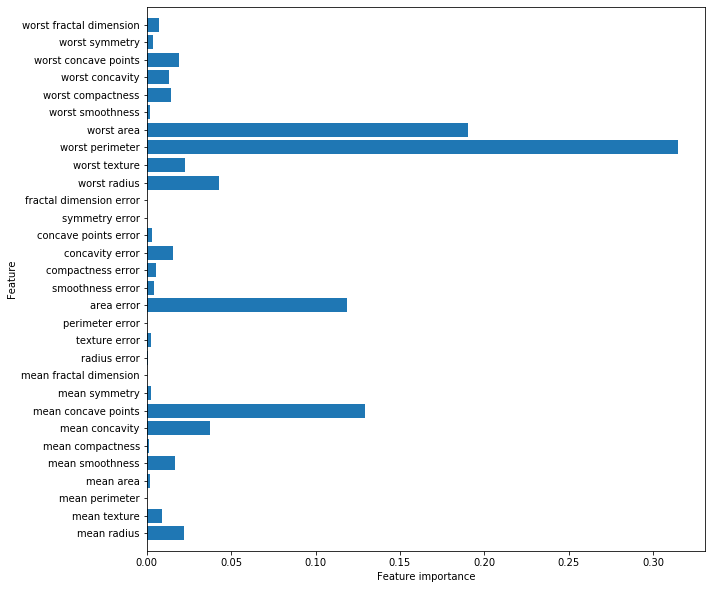

In [48]:
plt.figure(figsize=(10,10))
plot_feature_importances_cancer(rf)

As the graph shows above, we have non-zero importances for many more features than was observed for a single decision tree. This is because feature importances may vary between trees, but ensemble models like random forests can take all the trees, and their respective feature importances into account. In other words, the random forest captures a much broader picture of the data than a single tree.

Ensemble models are complex and not suited for interpretability. Hence, when showing examples to non-experts, decision trees can be used.

**You should keep in mind that random forests, by their nature, are random, and setting
different random states (or not setting the random_state at all) can drastically
change the model that is built. The more trees there are in the forest, the more robust
it will be against the choice of random state. If you want to have reproducible results,
it is important to fix the random_state.**

Random forests don't do well on very high dimensional, sparse data, such as text data. Linear models may be more appropriate in that case. Linear models are also preferable if processing time and memory are issues to be considered.

#### Warm starts
When you use Warm-Starts, you basically iteratively add more and more trees to the forest and you can stop whenever you think it's good enough.

In [50]:
train_scores = []
test_scores = []
rf = RandomForestClassifier(warm_start=True)
estimator_range = range(1, 100, 5)
for n_estimators in estimator_range:
    rf.n_estimators = n_estimators
    rf.fit(X_train, y_train)
    train_scores.append(rf.score(X_train, y_train))
    test_scores.append(rf.score(X_test, y_test))

In [55]:
len(train_scores)

20

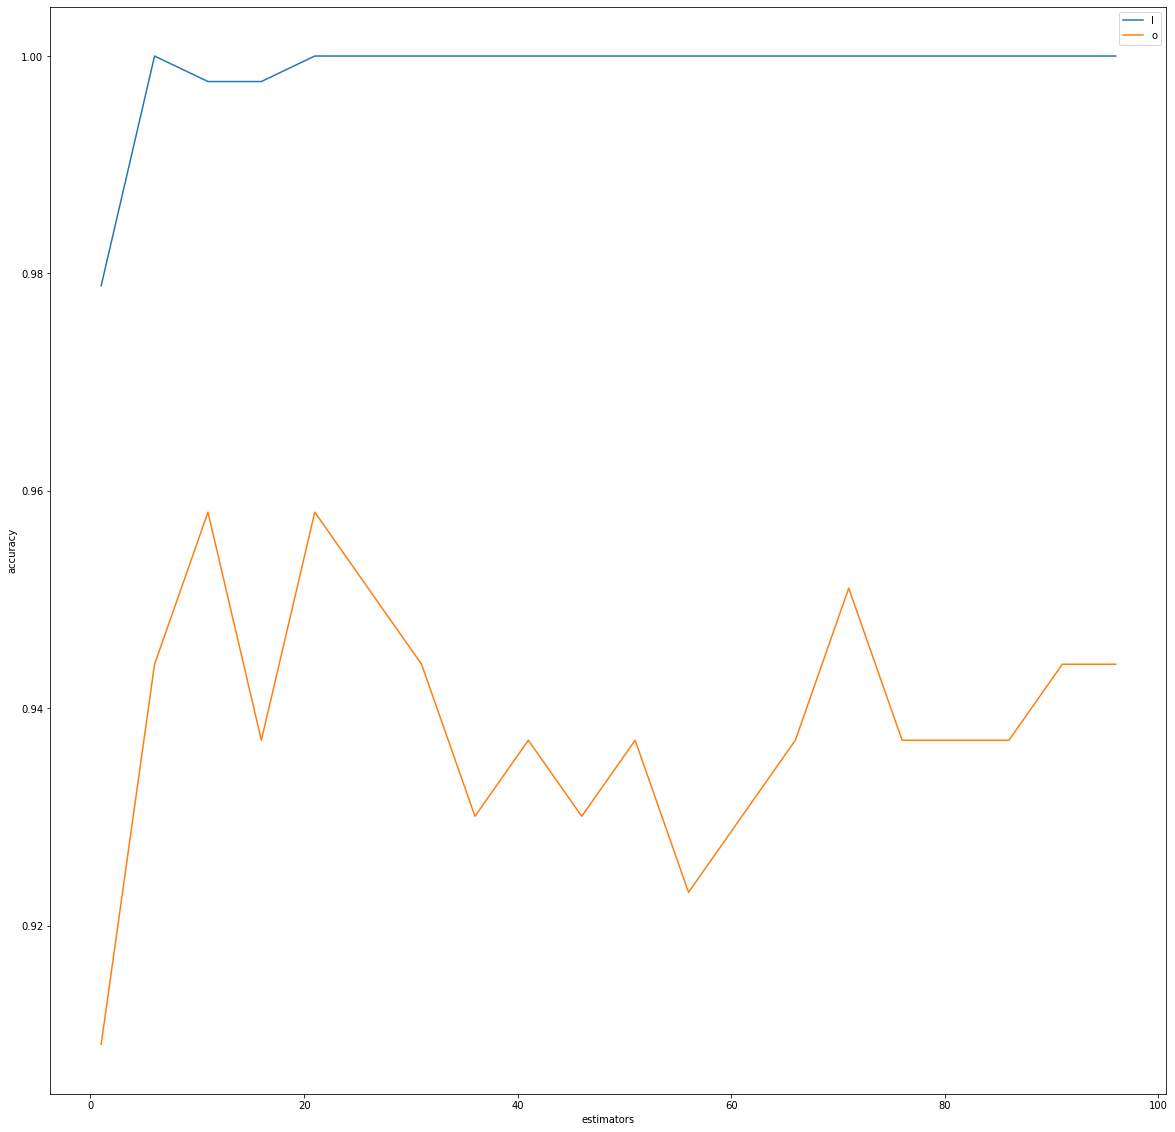

In [66]:
plt.figure(figsize=(20,20))
plt.plot(range(1, 100, 5), train_scores, label='Training scores')
plt.plot(range(1, 100, 5), test_scores, label='Test scores')
plt.xlabel('estimators')
plt.ylabel('accuracy')
plt.legend('lower left')
plt.show()

## Gradient boosting
For an introduction to gradient descent, refer to this tutorial, and the Khan academy video linked inside:   
https://towardsdatascience.com/machine-learning-101-an-intuitive-introduction-to-gradient-descent-366b77b52645   

First some discussion about SGDClassfier and SGDRegressor.

### SGD Classifier
Used for classification using gradient descent

### SGD Regession
USed for regression tasks using gradient descent


Using SGDClassifier on the breast cancer dataset:

In [77]:
X_train, X_test, y_train, y_test = train_test_split(cancer_data.data, cancer_data.target, random_state=0)

Creating batches of training data for `SGDClassifier`

In [178]:
max_index = len(X_train) - 1
batches = [(X_train[0:100, :], np.take(y_train, range(0,100))),
          (X_train[101:200, :], np.take(y_train, range(101,200))),
          (X_train[201:300, :], np.take(y_train, range(201,300))),
          (X_train[301:max_index, :], np.take(y_train, range(301,max_index)))]

np.random.shuffle(batches)

Accuracy for training data 0.913
Accuracy for test data 0.874
Accuracy for training data 0.894
Accuracy for test data 0.846


Showing `SGDCLassifier` with and without `partial_fit`. `partial_fit` allows us to iteratively feed data into the model. It is ideal for streaming or live data, where we can use it to keep feeding data to the model. Usually, when we call fit, the model retains no memory of what it fit before. `partial_fit` remembers what it saw before and keeps fitting the model.

In [179]:
sgd = SGDClassifier(eta0=0.05, learning_rate='adaptive')
for i in range(10): # iterating several times over batches improves results considerably
    for X_batch, y_batch in batches:
        sgd.partial_fit(X_batch, y_batch, classes=[0,1])

print("Accuracy for training data {:.3f}".format(sgd.score(X_train, y_train)))
print("Accuracy for test data {:.3f}".format(sgd.score(X_test, y_test)))

sgd2 = SGDClassifier(early_stopping=True)
sgd2.fit(X_train, y_train)
print("Accuracy for training data {:.3f}".format(sgd2.score(X_train, y_train)))
print("Accuracy for test data {:.3f}".format(sgd2.score(X_test, y_test)))

Accuracy for training data 0.913
Accuracy for test data 0.888
Accuracy for training data 0.899
Accuracy for test data 0.881


We get decent accuracy when we iterate over the batches multiple times, but the performance of the model is very unstable. We should use GridSearchCV to find the best parameters for the model. Parameter to be tuned: `learning rate`. There are many choices for loss functions.   
http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html

### Gradient Boosting

#### Concepts behind gradient boosting
- Gradient boosting works by building trees in a serial manner, where each tree tries to correct the mistakes of the previous one.
- String pre-pruning is used.
- Gradient boosting uses very shallow trees (also known as weak learners) having a depth of 1 to 5. It makes the model smaller in terms of memory and makes predictions faster.
- Each tree predicts well on a part of the data, so combining them makes for iteratively good perforomance.
- `learning_rate` is an important parameter to tune for gradient boosted models. It controls how quickly the model decreases error, or in this case, rectifies the mistakes of earlier trees.
- Higher `learning_rate` and `n_estimators` lead to a more complex model